In [1]:
import numpy as np
import numpy.random as npr
import scipy.stats as sps
import scipy.special as spsp
import scipy.misc as spm
import scipy.optimize as spo
import numpy.linalg as npl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
%matplotlib inline
import sympy as sym
import time
import seaborn as sns
import seaborn.distributions as snsd
import math as math
from label_lines import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


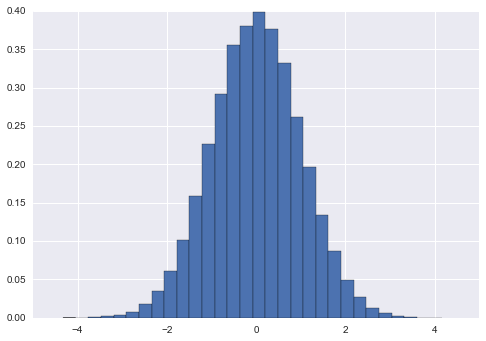

Mean of x = 0.00525302848968
Std of x = 0.998329273542


In [2]:
# Generate data
npr.seed(1)
N = 100000
dataType = "Gaussian"
#dataType = "logNormal"
x = npr.randn(N)

plt.clf()
plt.hist(x, 30, normed=True)
plt.show()

# We store the mean and std deviation for later reference, they are also the MAP and MLE estimates in this case.
realMean = np.mean(x)
realStd = np.std(x)
print "Mean of x =", realMean
print "Std of x =", realStd

#RWMH

In [3]:
def getLogLhd(x, mu, sigma):
    return -(x-mu)**2/(2*sigma**2) - np.log(sigma)

In [7]:
len(getLogLhd(x, realMean, realStd))

100000

In [130]:
def RWMH(T, mean):
    theta = np.array([mean,np.log(realStd)])
    stepsize = .5/np.sqrt(N)
    S = np.zeros((T, 2))
    acceptance = 0.0
    f = FloatProgress(min=0, max=T)
    display(f)
    for i in range(T):
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        ratio = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        Lambda = np.mean(ratio)
        psi = 1./N*np.log(u)
        if Lambda>psi:
            thetaNew = thetaP
            theta = thetaP
            accepted = 1
            S[i,:] = thetaNew
        else:
            S[i,:] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        f.value = i
            
    return S

#ULA

In [8]:
Gradient = lambda x_float, mu_float, sigma_float:np.array([-(2*mu_float - 2*x_float)/(2*sigma_float**2), -1/sigma_float + (-mu_float + x_float)**2/sigma_float**3]).T
Hessian = lambda x_float, mu_float, sigma_float:[[-1/sigma_float**2*np.ones(x_float.shape), 2*(mu_float - x_float)/sigma_float**3], [2*(mu_float - x_float)/sigma_float**3, (1 - 3*(mu_float - x_float)**2/sigma_float**2)/sigma_float**2]]

In [132]:
def langevin(T,mean):
    theta = np.array([mean, np.log(realStd)])
    S = np.zeros((T,2))
    M = N/10. # Size of the subsample
    f = FloatProgress(min=0, max=T)
    display(f) 
    for i in range(T):
        stepsize = .1/N/((i+1)**.33)
        inds = npr.randint(0,N,size=M)
        gradEstimate = N/M*np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0)
        theta[0] = theta[0] + stepsize*gradEstimate[0] + np.sqrt(stepsize)*npr.randn()
        theta[1] = np.log(np.exp(theta[1]) + stepsize*gradEstimate[1] + np.sqrt(stepsize)*npr.randn())
        S[i,:] = theta
        f.value = i  
            
    return S

#MALA

In [134]:
def mala(T,mean):
    theta = np.array([mean, np.log(realStd)])
    thetaP = np.array([mean, np.log(realStd)])
    S = np.zeros((T,2))
    acceptance = 0.0
    M = N/10. # Size of the subsample
    f = FloatProgress(min=0, max=T)
    display(f)
    
    for i in range(T):
        accepted = 0
        stepsize = .1/N/((i+1)**.33)
        inds = npr.randint(0,N,size=M)
        gradEstimate = N/M*np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0)
        #print gradEstimate
        thetaP[0] = theta[0] + stepsize*gradEstimate[0] + np.sqrt(stepsize)*npr.randn()
        thetaP[1] = np.log(np.exp(theta[1]) + stepsize*gradEstimate[1] + np.sqrt(stepsize)*npr.randn())
        u = npr.rand()
        ratio = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        Lambda = np.mean(ratio)
        psi = 1./N*np.log(u)
        if Lambda>psi:
            thetaNew = thetaP
            theta = thetaP
            accepted = 1
            S[i,:] = thetaNew
        else:
            S[i,:] = theta
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        f.value = i   
            
    return S

#ULA with Hessian as D

In [133]:
def langevin_d(T,mean):
    theta = np.array([mean, np.log(realStd)])
    S = np.zeros((T,2))
    M = N/10. # Size of the subsample
    gamma=0.01
    f = FloatProgress(min=0, max=T)
    display(f)
    for i in range(T):
        #stepsize = .1/N/((i+1)**.33)
        inds = npr.randint(0,N,size=M)
        hessianestim = np.sum(Hessian(x[inds], theta[0], np.exp(theta[1])), 0) 
        stepsize = .1/(N*abs(hessianestim[0][i]))/((i+1)**.33)
        gradEstimate = N/M*np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0)
        theta[0] = theta[0] + stepsize*gradEstimate[0] + np.sqrt(2*stepsize)*npr.randn()
        theta[1] = np.log(np.exp(theta[1]) + stepsize*gradEstimate[1] + np.sqrt(stepsize)*npr.randn())
        S[i,:] = theta
        f.value = i
    return S

#ULA with FIM as D

In [135]:
def langevin_fim(T,mean):
    theta = np.array([mean, np.log(realStd)])
    S = np.zeros((T,2))
    M = N/10. # Size of the subsample
    gamma=0.01
    f = FloatProgress(min=0, max=T)
    display(f)
    for i in range(T):
        #stepsize = .1/N/((i+1)**.33)
        inds = npr.randint(0,N,size=M)
        fim = np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0) 
        stepsize = .1/(N*abs(fim[0]))/((i+1)**.33)
        gradEstimate = N/M*np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0)
        theta[0] = theta[0] + stepsize*gradEstimate[0] + np.sqrt(2*stepsize)*npr.randn()
        theta[1] = np.log(np.exp(theta[1]) + stepsize*gradEstimate[1] + np.sqrt(stepsize)*npr.randn())
        S[i,:] = theta
        f.value = i
            
    return S

###OPTIM TO SAMPLING

#ULA with Nesterov descent

In [7]:
def langevin_nesterov(T,mean):
    theta = np.array([mean, np.log(realStd)])
    S = np.zeros((T,2))
    M = N/10. # Size of the subsample
    sigma = 0.01
    L1=[theta[0]]
    L2=[theta[1]]
    f = FloatProgress(min=0, max=T)
    display(f)
    for i in range(T):
        if i == 0:
            stepsize = .1/N/((i+1)**.33)
            inds = npr.randint(0,N,size=M)
            gradEstimate = N/M*np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0)
            theta[0] = theta[0] + stepsize*gradEstimate[0] + np.sqrt(stepsize)*npr.randn()
            theta[1] = np.log(np.exp(theta[1]) + stepsize*gradEstimate[1] + np.sqrt(stepsize)*npr.randn())
            L1.append(theta[0])
            L2.append(theta[1])
            S[i,:] = theta
        else:
            stepsize = .1/N/((i+1)**.33)
            inds = npr.randint(0,N,size=M)
            gradEstimate = N/M*np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0)
            theta[0] = theta[0] + stepsize*gradEstimate[0] + sigma(theta[0] - L1(i-1)) + np.sqrt(stepsize)*npr.randn()
            theta[1] = np.log(np.exp(theta[1]) + stepsize*gradEstimate[1] + sigma(theta[1] - L1(i-1)) + np.sqrt(stepsize)*npr.randn())
            L1.append(theta[0])
            L2.append(theta[1])
            S[i,:] = theta
        f.value = i  
            
    return S

#ULA updating by block

In [8]:
def langevin_block(T,mean):
    theta = np.array([mean, np.log(realStd)])
    S = np.zeros((T,2))
    M = N/10. # Size of the subsample
    f = FloatProgress(min=0, max=T)
    display(f) 
    for i in range(T):
        stepsize = .1/N/((i+1)**.33)
        inds = npr.randint(0,N,size=M)
        gradEstimate = N/M*np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0)
        theta[0] = theta[0] + stepsize*gradEstimate[0] + np.sqrt(stepsize)*npr.randn()
        theta[1] = np.log(np.exp(theta[1]) + stepsize*gradEstimate[1] + np.sqrt(stepsize)*npr.randn())
        S[i,:] = theta
        f.value = i  
            
    return S

##Comparison

###RWMH vs ULA

In [13]:
niters = 10000
samples_rwmh = [RWMH(niters, mean) for mean in np.arange(0.1, 4, 1)]
samples_ula = [langevin(niters, mean) for mean in np.arange(0.1, 4, 1)]

Iteration 0 Acceptance 0.0
Iteration 1000 Acceptance 0.52047952048
Iteration 2000 Acceptance 0.529735132434
Iteration 3000 Acceptance 0.538487170943
Iteration 4000 Acceptance 0.538615346163
Iteration 5000 Acceptance 0.540091981604
Iteration 6000 Acceptance 0.541243126146
Iteration 7000 Acceptance 0.538494500786
Iteration 8000 Acceptance 0.536057992751
Iteration 9000 Acceptance 0.531940895456
Iteration 0 Acceptance 1.0
Iteration 1000 Acceptance 0.503496503497
Iteration 2000 Acceptance 0.545227386307
Iteration 3000 Acceptance 0.581472842386
Iteration 4000 Acceptance 0.594851287178
Iteration 5000 Acceptance 0.608278344331
Iteration 6000 Acceptance 0.62006332278
Iteration 7000 Acceptance 0.625767747465
Iteration 8000 Acceptance 0.629796275466
Iteration 9000 Acceptance 0.63226308188
Iteration 0 Acceptance 0.0
Iteration 1000 Acceptance 0.490509490509
Iteration 2000 Acceptance 0.506746626687
Iteration 3000 Acceptance 0.506831056315
Iteration 4000 Acceptance 0.512871782054
Iteration 5000 Accep

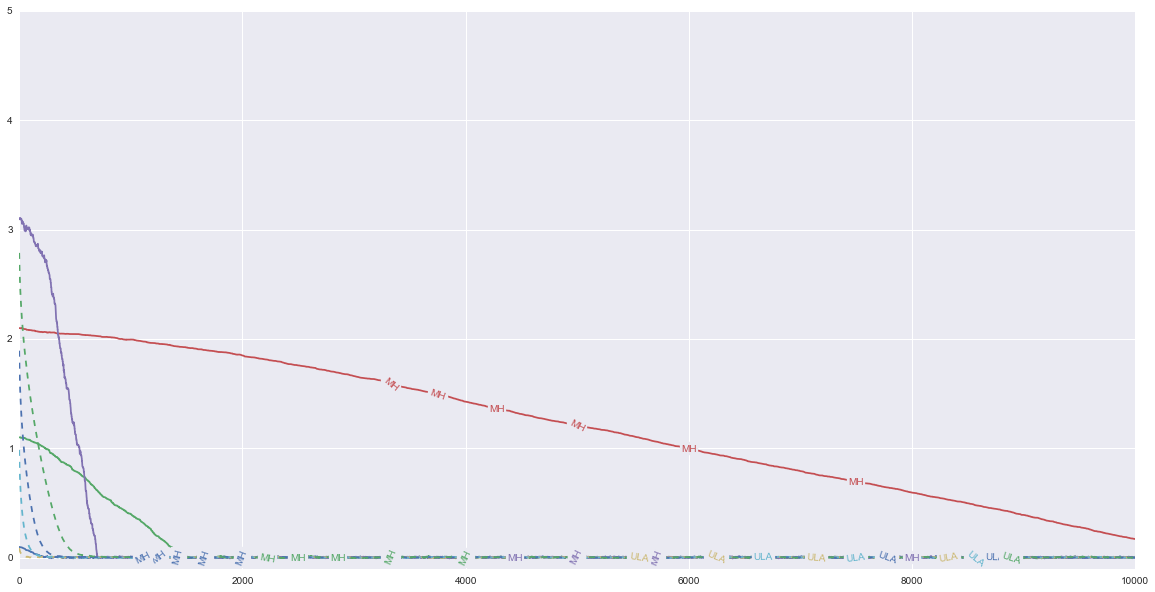

In [22]:
#several chain
plt.figure(figsize=(20,10))
for samples in samples_rwmh:
    plt.plot(samples[:,0], '-',label=str('MH'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
for samples in samples_ula:
    plt.plot(samples[:,0], '--',label=str('ULA'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, niters])
plt.ylim([-0.1, 5]);

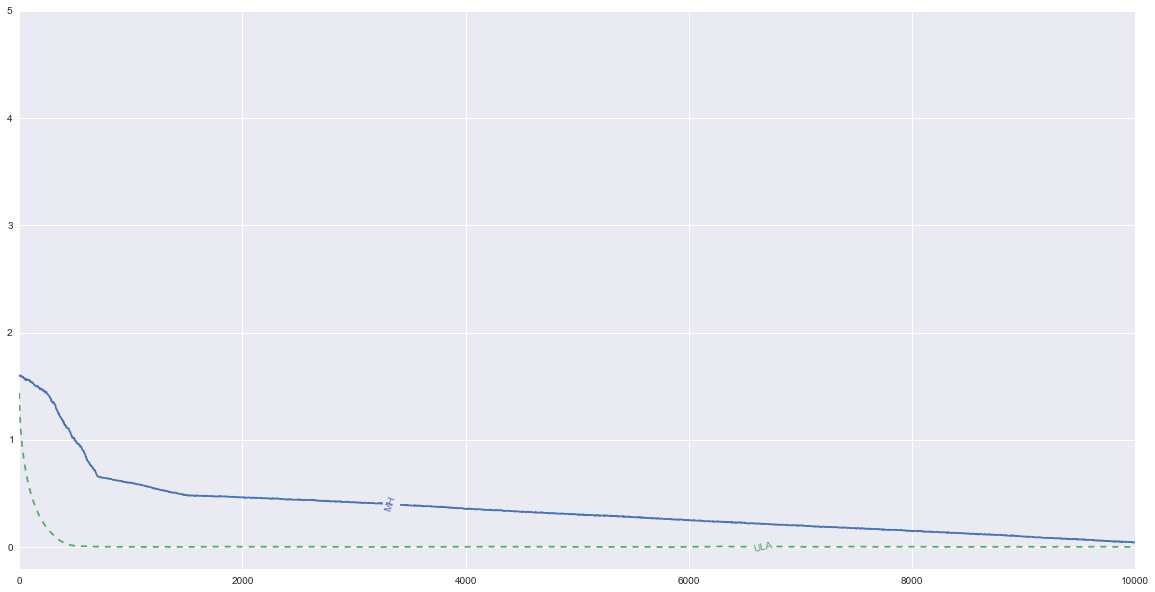

In [27]:
#averaged
rwmh = sum(samples_rwmh)/len(np.arange(0.1, 4, 1))
ula = sum(samples_ula)/len(np.arange(0.1, 4, 1))
plt.figure(figsize=(20,10))
plt.plot(rwmh[:,0], '-',label=str('MH'))
plt.plot(ula[:,0], '--',label=str('ULA'))
labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, niters])
plt.ylim([-0.2, 5]);

###ULA vs ULA_hessian

In [35]:
niters = 10000
samples_ula = [langevin(niters, mean) for mean in np.arange(0.1, 4, 1)]
samples_ulad = [langevin_d(niters, mean) for mean in np.arange(0.1, 4, 1)]

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


TypeError: langevin_d() takes exactly 1 argument (2 given)

In [68]:
samples_ulad = [langevin_d(niters, mean) for mean in np.arange(0.1, 4, 1)]

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!


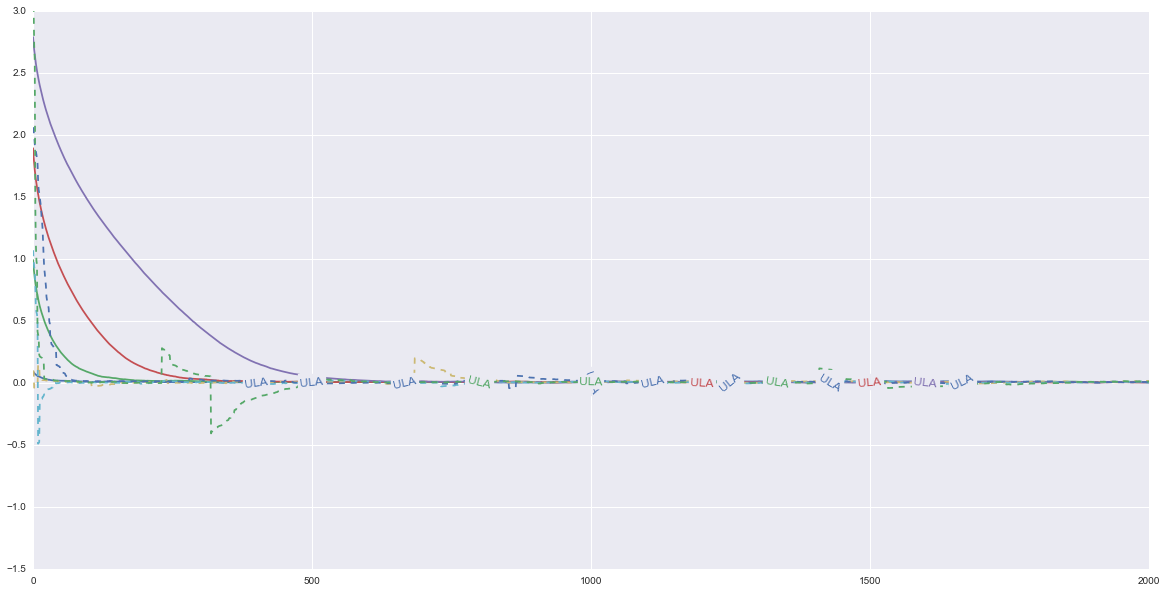

In [102]:
#several chain
plt.figure(figsize=(20,10))
for samples in samples_ula:
    plt.plot(samples[:,0], '-',label=str('ULA'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
for samples in samples_ulad:
    plt.plot(samples[:,0], '--',label=str('hess'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, niters])
plt.ylim([-1.5, 3]);

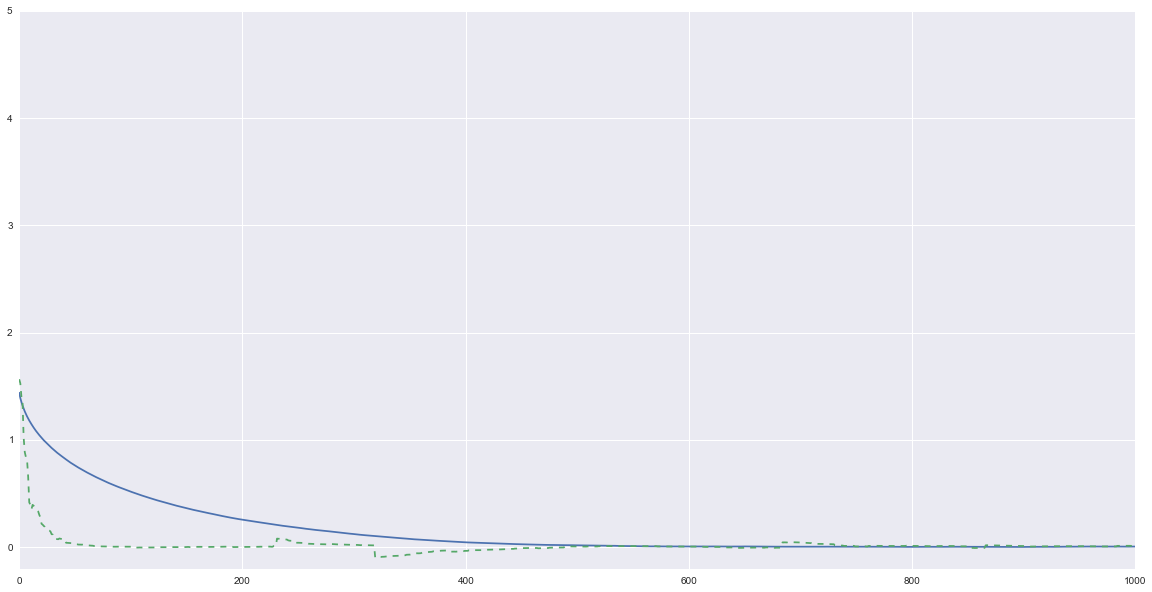

In [73]:
#averaged
ula = sum(samples_ula)/len(np.arange(0.1, 4, 1))
hess = sum(samples_ulad)/len(np.arange(0.1, 4, 1))
plt.figure(figsize=(20,10))
plt.plot(ula[:,0], '-',label=str('ULA'))
plt.plot(hess[:,0], '--',label=str('Hess'))
labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, 1000])
plt.ylim([-0.2, 5]);

##ULA vs ULA_Nesterov

In [ ]:
niters = 10000
samples_ula = [langevin(niters, mean) for mean in np.arange(0.1, 4, 1)]
samples_ulanest = [langevin_nesterov(niters, mean) for mean in np.arange(0.1, 4, 1)]

In [ ]:
#several chain
plt.figure(figsize=(20,10))
for samples in samples_ula:
    plt.plot(samples[:,0], '-',label=str('ULA'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
for samples in samples_ulanest:
    plt.plot(samples[:,0], '--',label=str('Nesterov'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, niters])
plt.ylim([-1.5, 3]);

In [ ]:
#averaged
ula = sum(samples_ula)/len(np.arange(0.1, 4, 1))
nesterov = sum(samples_ulanest)/len(np.arange(0.1, 4, 1))
plt.figure(figsize=(20,10))
plt.plot(ula[:,0], '-',label=str('ULA'))
plt.plot(nesterov[:,0], '--',label=str('Nesterov'))
labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, 1000])
plt.ylim([-0.2, 5]);

###ULA vs ULA by block

In [ ]:
niters = 10000
samples_ula = [langevin(niters, mean) for mean in np.arange(0.1, 4, 1)]
samples_ulablock = [langevin_block(niters, mean) for mean in np.arange(0.1, 4, 1)]

In [ ]:
#several chain
plt.figure(figsize=(20,10))
for samples in samples_ula:
    plt.plot(samples[:,0], '-',label=str('ULA'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
for samples in samples_ulablock:
    plt.plot(samples[:,0], '--',label=str('Block'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, niters])
plt.ylim([-1.5, 3]);

In [ ]:
#averaged
ula = sum(samples_ula)/len(np.arange(0.1, 4, 1))
block = sum(samples_ulablock)/len(np.arange(0.1, 4, 1))
plt.figure(figsize=(20,10))
plt.plot(ula[:,0], '-',label=str('ULA'))
plt.plot(block[:,0], '--',label=str('Block'))
labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, 1000])
plt.ylim([-0.2, 5]);

###ULA vs ULA_fim

In [120]:
def langevin_fim(T,mean):
    theta = np.array([mean, np.log(realStd)])
    S = np.zeros((T,2))
    ns = []
    M = N/10. # Size of the subsample
    weights = np.zeros((T,))
    gamma=0.01
    f = FloatProgress(min=0, max=T)
    display(f)
    for i in range(T):
        #stepsize = .1/N/((i+1)**.33)
        inds = npr.randint(0,N,size=M)
        fim = np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0)
        stepsize = .1/(N*abs(fim[0]))/((i+1)**.33)
        gradEstimate = N/M*np.sum(Gradient(x[inds], theta[0], np.exp(theta[1])), 0)
        theta[0] = theta[0] + stepsize*gradEstimate[0] + np.sqrt(2*stepsize)*npr.randn()
        theta[1] = np.log(np.exp(theta[1]) + stepsize*gradEstimate[1] + np.sqrt(stepsize)*npr.randn())
        ns.append(M)
        S[i,:] = theta
        f.value = i    
    return S

In [121]:
niters = 2000
samples_fim = [langevin_fim(niters, mean) for mean in np.arange(0.1, 4, 1)]

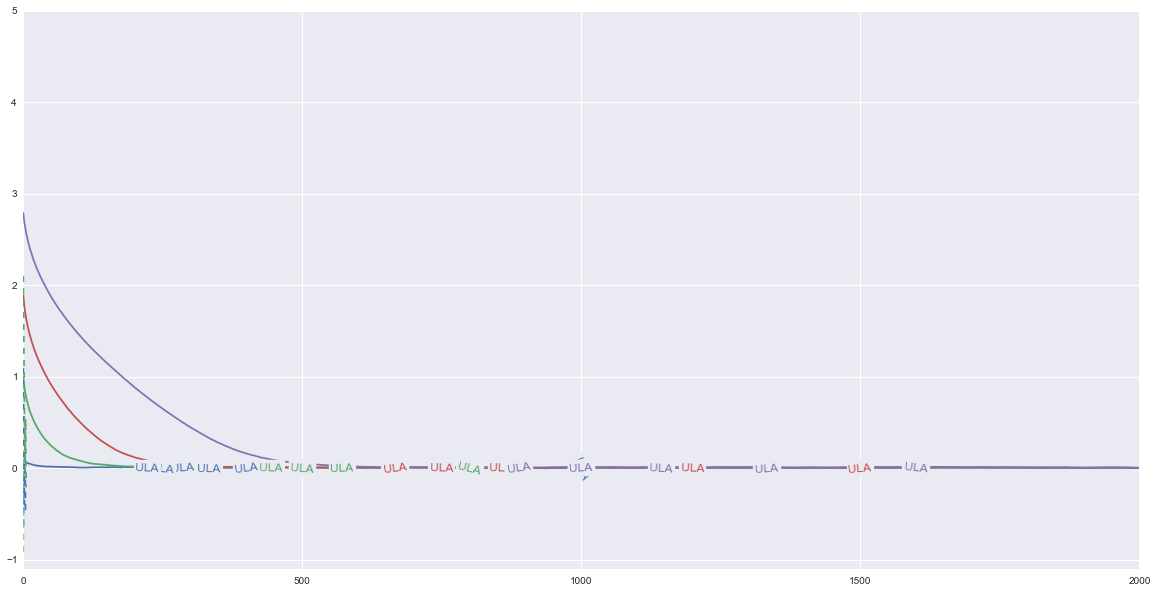

In [109]:
#several chain
plt.figure(figsize=(20,10))
for samples in samples_ula:
    plt.plot(samples[:,0], '-',label=str('ULA'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
for samples in samples_fim:
    plt.plot(samples[:,0], '--',label=str('ULA_fim'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, niters])
plt.ylim([-1.1, 5]);

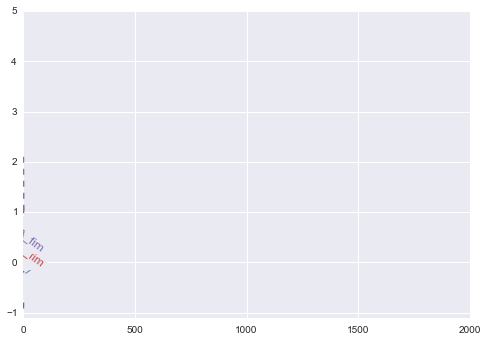

In [110]:
for samples in samples_fim:
    plt.plot(samples[:,0], '--',label=str('ULA_fim'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, niters])
plt.ylim([-1.1, 5]);

gradient of log Pi where Pi is a gaussian

In [13]:
def langevin(T,mean):
    theta = np.array([mean, np.log(realStd)])
    S = np.zeros((T,2))
    M = N/10. # Size of the subsample
    for i in range(T):
        stepsize = .1/N/((i+1)**.33)
        inds = npr.randint(0,N,size=M)
        gradEstimate = N/M*np.sum(Gradient(getLogLhd(x[inds], theta[0], np.exp(theta[1])), theta[0], np.exp(theta[1])), 0)
        theta[0] = theta[0] - stepsize*gradEstimate[0] + np.sqrt(stepsize)*npr.randn()
        theta[1] = np.log(np.exp(theta[1]) - stepsize*gradEstimate[1] + np.sqrt(stepsize)*npr.randn())
        S[i,:] = theta

            
    return S

In [14]:
niters = 10000
samples_ula = [langevin(niters, mean) for mean in np.arange(0.1, 4, 1)]

In [16]:
samples_ula

[array([[ 0.1608661 ,  0.01191488],
        [ 0.21379706,  0.01816811],
        [ 0.26270915,  0.02104606],
        ..., 
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]]), array([[ 1.31853408, -0.79689694],
        [ 4.1851132 ,         nan],
        [        nan,         nan],
        ..., 
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]]), array([[ 2.57744172,         nan],
        [        nan,         nan],
        [        nan,         nan],
        ..., 
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]]), array([[ 3.94539207,         nan],
        [        nan,         nan],
        [        nan,         nan],
        ..., 
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]])]

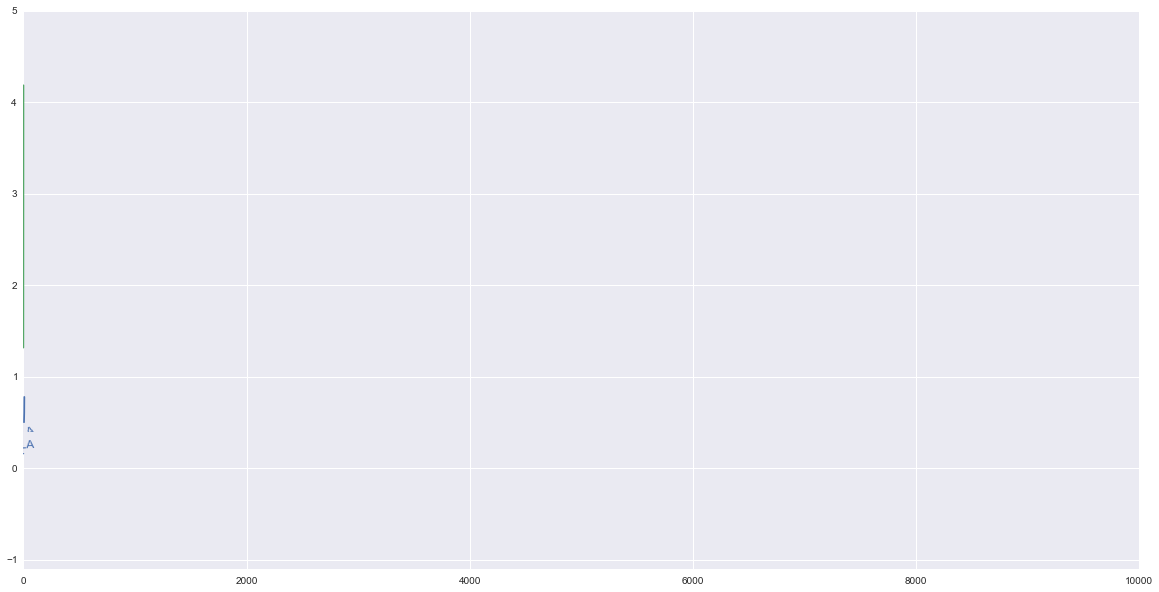

In [15]:
#several chain
plt.figure(figsize=(20,10))
for samples in samples_ula:
    plt.plot(samples[:,0], '-',label=str('ULA'))
    labelLines(plt.gca().get_lines(),zorder=2.5)
plt.xlim([0, niters])
plt.ylim([-1.1, 5]);